# Load Libraries

In [1]:
import os
import random
from PIL import Image
import cv2
import tifffile as tiff
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

import tensorflow as tf
from keras.utils import plot_model
from tensorflow.keras import Model
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Input, Dropout, UpSampling2D, concatenate, Conv2DTranspose
from keras.regularizers import l2
from keras.optimizers import Adamax, Adam
from tensorflow.keras.metrics import Accuracy, Precision, Recall, BinaryIoU
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0

os.environ['SM_FRAMEWORK'] = 'tf.keras'
from segmentation_models import Unet, Linknet


Segmentation Models: using `tf.keras` framework.


d:\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


# Read and Prepare Data

In [2]:
dataset_path = '../satalite data/data'
dataset_dir = os.listdir(dataset_path)
print(f'The Dataset directory constists of {dataset_dir} directories.')

The Dataset directory constists of ['images', 'labels'] directories.


In [3]:
image_dir = dataset_path + '/images'
image_paths = sorted(glob(os.path.join(image_dir, "*.tif")))
images = [tiff.imread(image_path) for image_path in image_paths]

In [4]:
mask_dir = dataset_path + '/labels'

# Exclude file containing '_' in their name
mask_paths = [c for c in sorted(glob(os.path.join(mask_dir, "*.png"))) if "_" not in os.path.basename(c)]
masks = [cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) for mask_path in mask_paths]

# Data Preprocessing

> Apply Normalization

In [5]:
def preprocess_global(dataset):
    num_bands = dataset[0].shape[-1]
    global_mins = np.full(num_bands, np.inf)
    global_maxs = np.full(num_bands, -np.inf)
    
    for img in dataset:
        for b in range(num_bands):
            global_mins[b] = min(global_mins[b], np.min(img[:, :, b]))
            global_maxs[b] = max(global_maxs[b], np.max(img[:, :, b]))

    band_stats = pd.DataFrame({
        'Band': [f'Band {i+1}' for i in range(num_bands)],
        'Min': global_mins,
        'Max': global_maxs
    })
    
    norm_dataset = []
    for img in dataset:
        norm_img = np.zeros_like(img, dtype=np.float32)
        for b in range(num_bands):
            norm_img[:, :, b] = (img[:, :, b] - global_mins[b]) / (global_maxs[b] - global_mins[b] + 1e-5)
        norm_dataset.append(norm_img)
    return band_stats, norm_dataset

In [6]:
bands, images = preprocess_global(images)
print('== Original min and max for bands before applying normalization ==')
bands

== Original min and max for bands before applying normalization ==


Band     Min      Max
0    Band 1 -1393.0   6568.0
1    Band 2 -1169.0   9659.0
2    Band 3  -722.0  11368.0
3    Band 4  -684.0  12041.0
4    Band 5  -412.0  15841.0
5    Band 6  -335.0  15252.0
6    Band 7  -258.0  14647.0
7    Band 8    64.0    255.0
8    Band 9 -9999.0   4245.0
9   Band 10     8.0   4287.0
10  Band 11    10.0    100.0
11  Band 12     0.0    111.0

# Data Visualization

## Band Visualization functions

In [7]:
def plot_band_histograms(images, bins=50):
    fig, axes = plt.subplots(3, 4, figsize=(20, 10))
    axes = axes.flatten()
    fig.suptitle('Histogram of Pixel Distribution', fontsize=15)

    for b in range(12):
        band_pixels = []
        for img in images:
            band_pixels.extend(img[:, :, b].flatten())
        
        axes[b].hist(band_pixels, bins=bins, edgecolor='black')
        axes[b].set_title(f'Band {b+1}')
        axes[b].set_xlabel('Pixel Value')
        axes[b].set_ylabel('Frequency')
        axes[b].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()


In [8]:
def visualize_image_bands(image, title='Image Bands'):
    num_bands = image.shape[-1]
    bands = ['Coastal aerosal', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'QA Band'
             , 'Merit DEM', 'Copernicus DEM', 'ESA world cover map', 'Water occurence probability']
    fig, axes = plt.subplots(1, num_bands, figsize=(25, 3))
    fig.suptitle(title, fontsize=15)

    for i in range(num_bands):
        ax = axes[i] if num_bands > 1 else axes
        ax.imshow(image[:, :, i], cmap='gray')
        ax.set_title(f'Band {i + 1}\n{bands[i]}', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## visualize histograms of pixel distributions per band

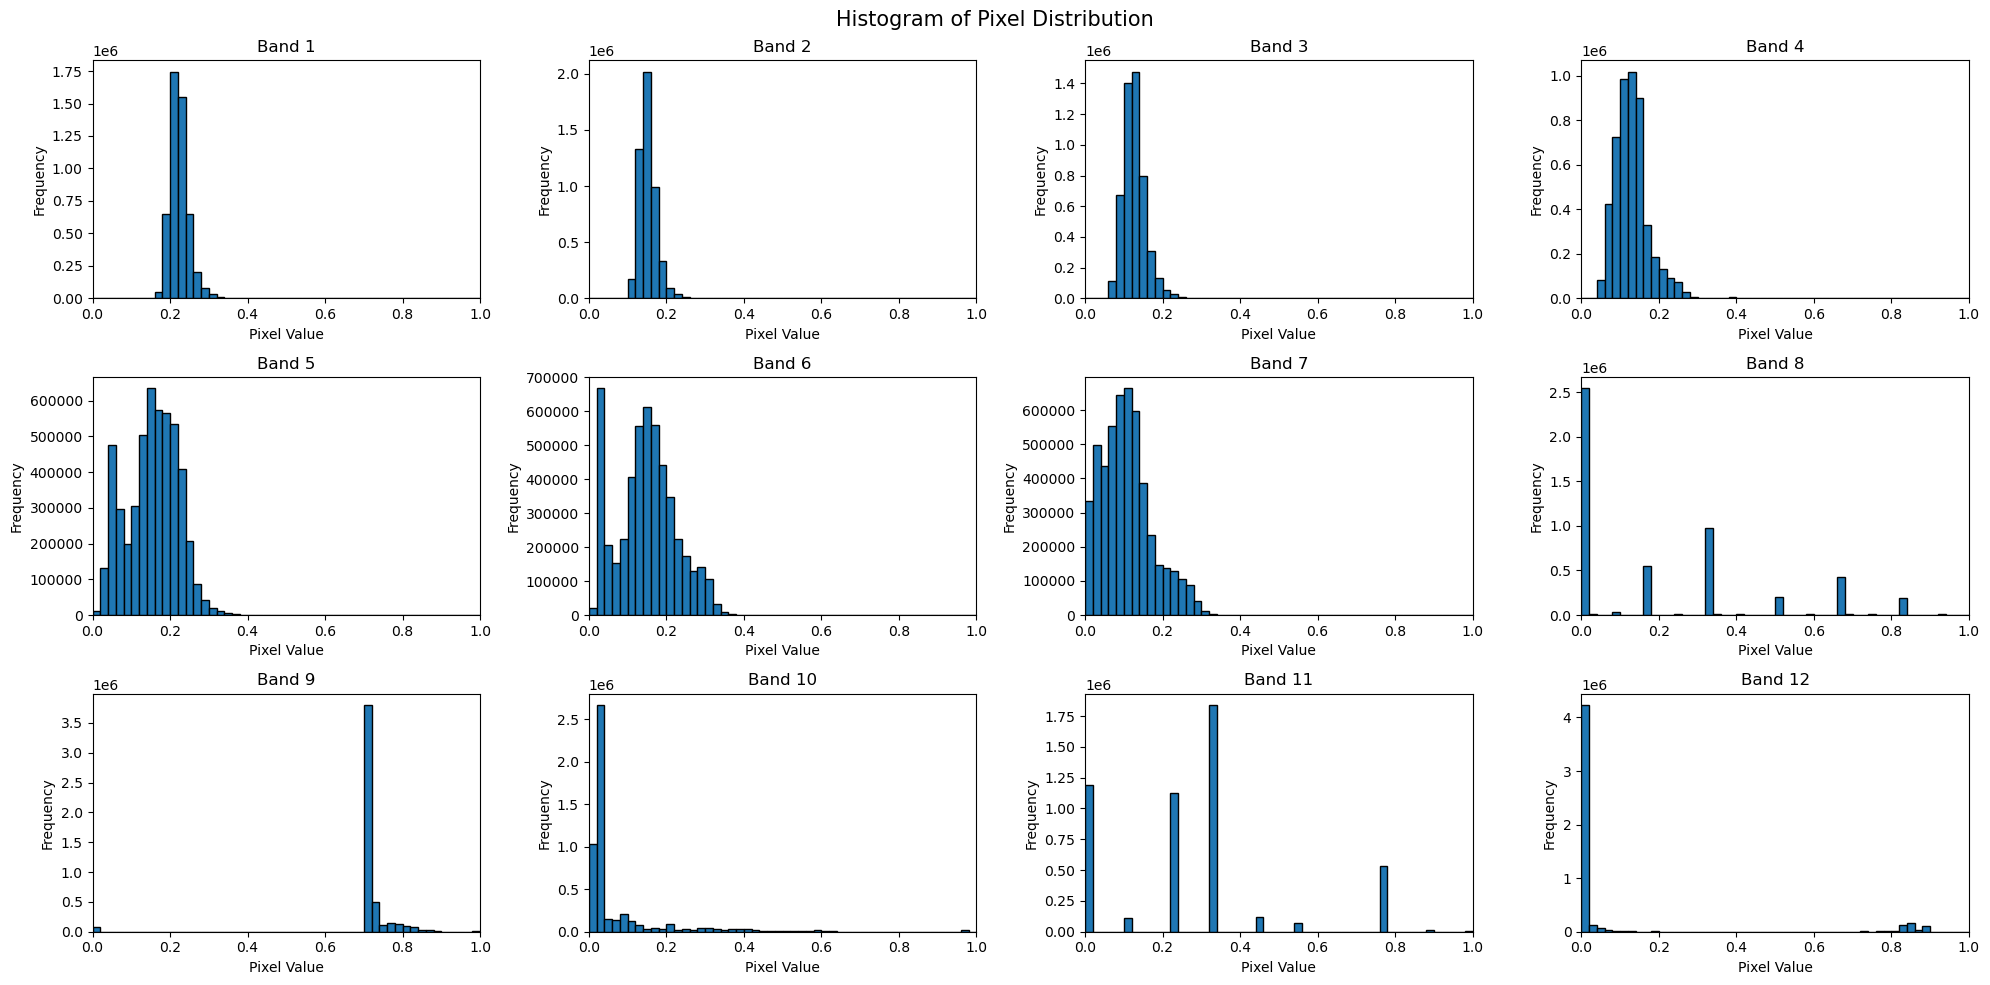

In [9]:
plot_band_histograms(images)


## visualize the bands of first 5 images

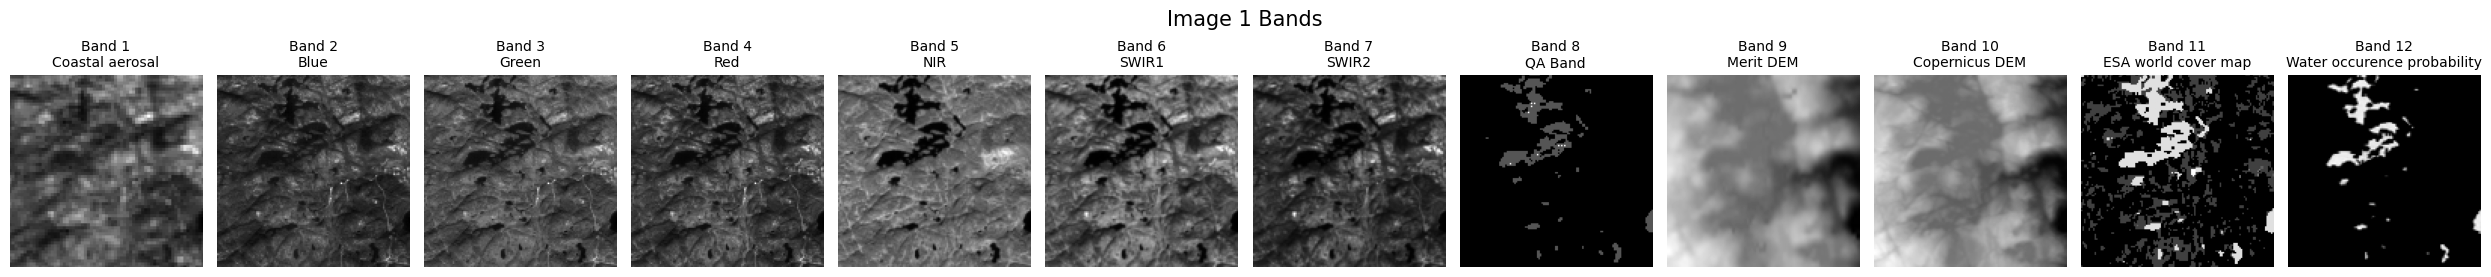

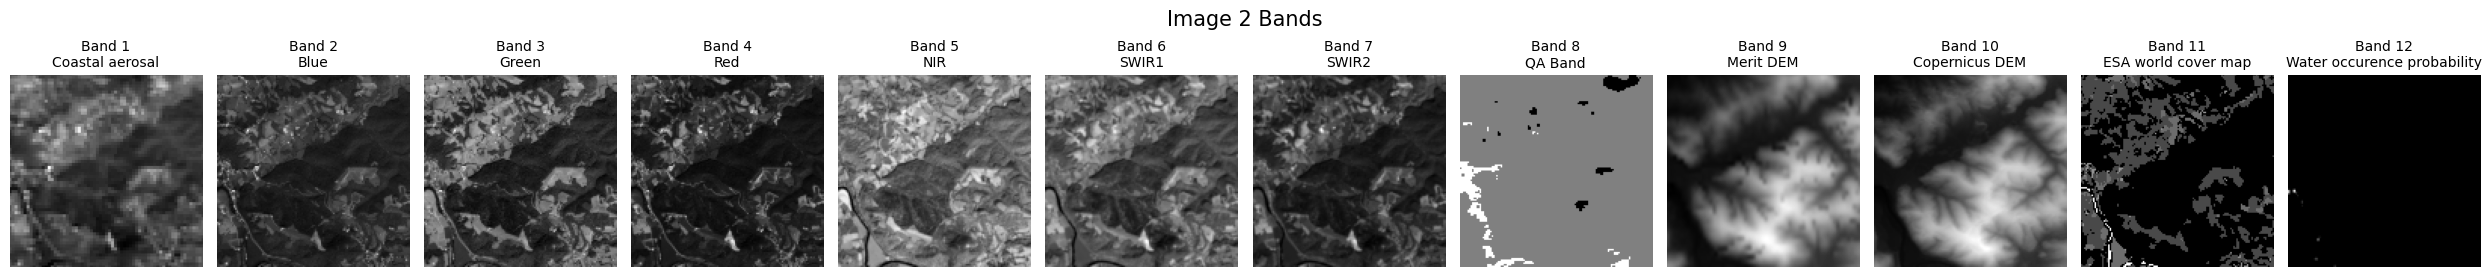

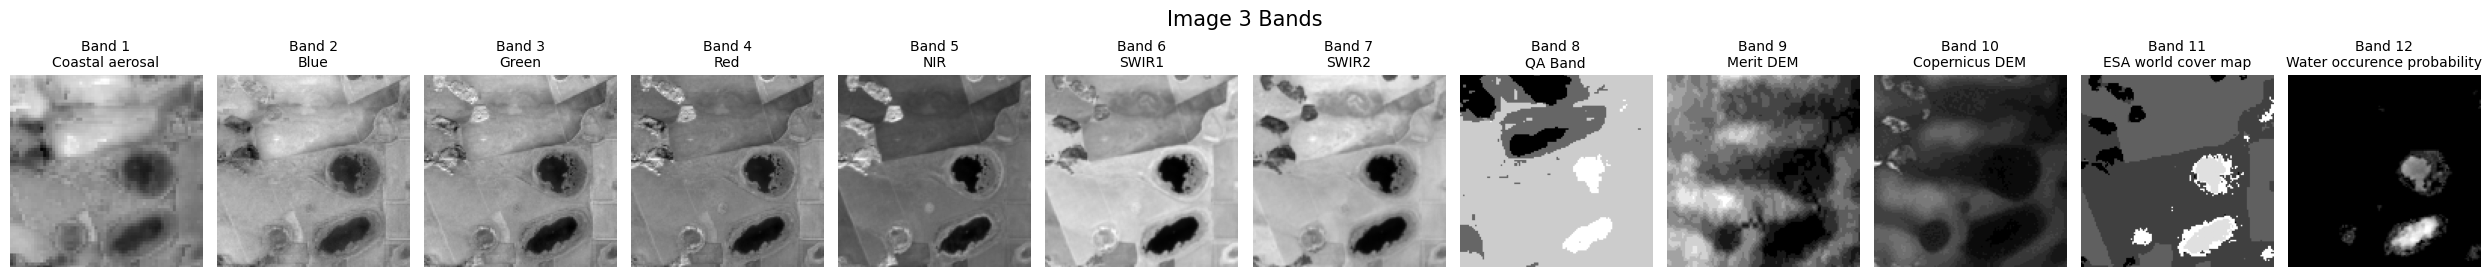

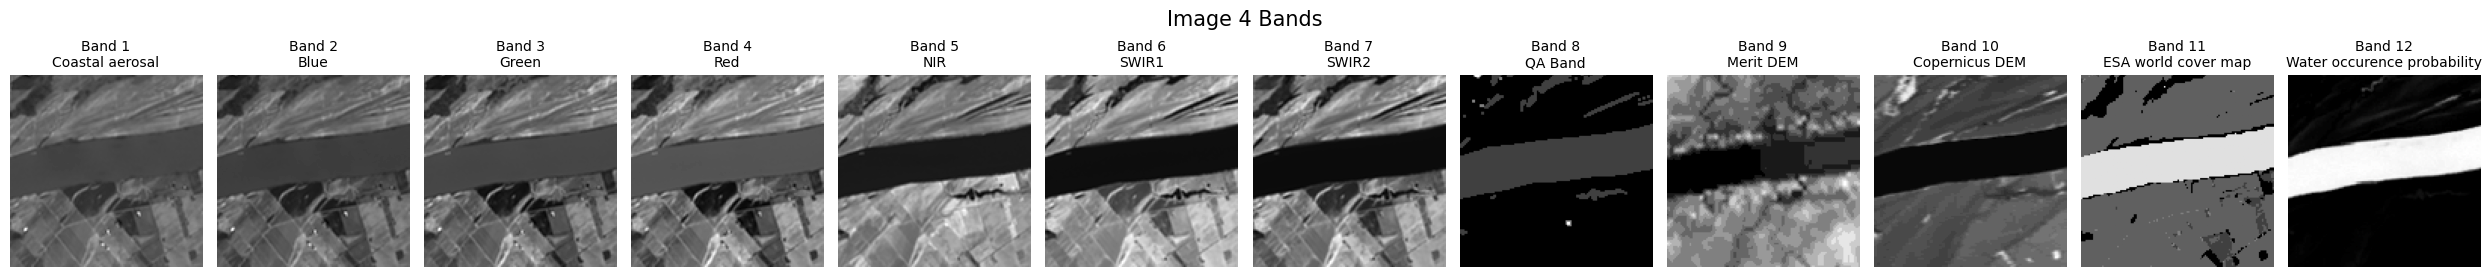

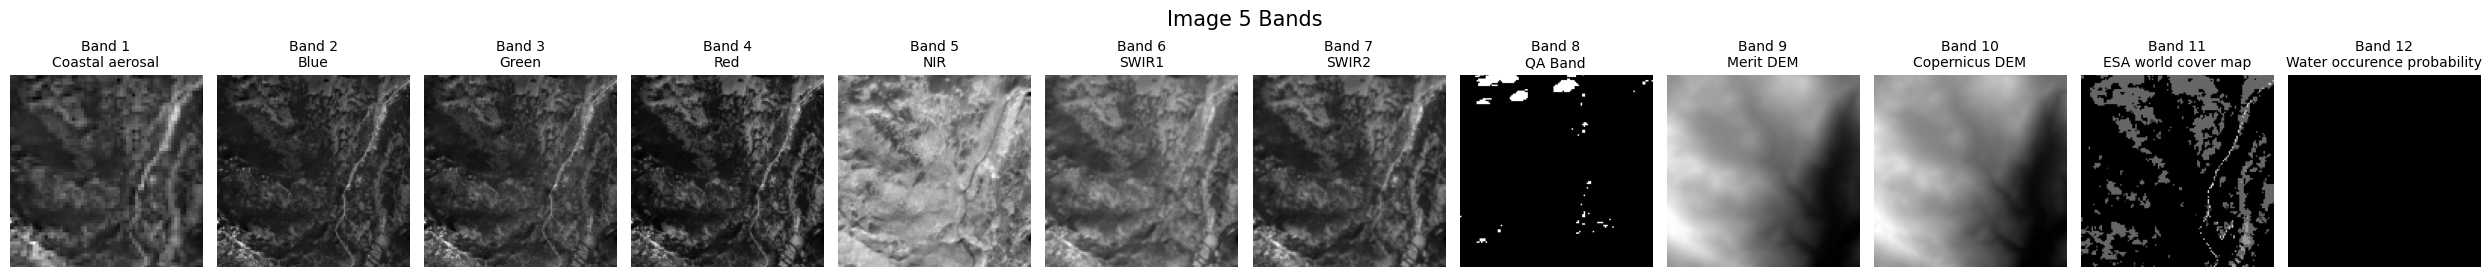

In [10]:
for i in range(5):
    visualize_image_bands(images[i], f'Image {i + 1} Bands')

> split data into 80% for training and 20% for testing

In [11]:
train_size = int(0.8 * len(images))

x_train, x_test = images[:train_size], images[train_size:]
y_train, y_test = masks[:train_size], masks[train_size:]

In [12]:
print (f'x_train shape: {np.array(x_train).shape}\nx_test shape: {np.array(x_test).shape}')

x_train shape: (244, 128, 128, 12)
x_test shape: (62, 128, 128, 12)


# Model Architecture

## Build Functions

In [13]:
def train(model):
    model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy',
                          BinaryIoU(target_class_ids=[1], threshold=0.5, name='iou'),
                          Precision(name='precision'),
                          Recall(name='recall')])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    # Train model
    history = model.fit(
        np.array(x_train), np.array(y_train),
        validation_data=(np.array(x_test), np.array(y_test)),
        epochs=100, batch_size=32, callbacks=[early_stop])

    return history

In [14]:
def model_evaluation(model):
    train_loss, train_acc, train_iou, train_prec, train_rec = model.evaluate(np.array(x_train), np.array(y_train))
    test_loss, test_acc, test_iou, test_prec, test_rec = model.evaluate(np.array(x_test), np.array(y_test))
    
    def f1_score(precision, recall):
        return 2 * (precision * recall) / (precision + recall + 1e-5)
    
    train_f1 = f1_score(train_prec, train_rec)
    test_f1 = f1_score(test_prec, test_rec)

    print('== Training ==\n' +\
      f'Accuracy: {train_acc:.4f}, IoU: {train_iou:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, F1_Score: {train_f1:.4f}\n\n' +\
      '== Testing ==\n' +\
      f'Accuracy: {test_acc:.4f}, IoU: {test_iou:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}, F1_Score: {test_f1:.4f}'
     )

In [15]:
def Loss_Acc_Evol(history):
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='b')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='m')
    plt.legend()
    plt.title('Loss Evolution')
    
    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='b')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='m')
    plt.legend()
    plt.title('Accuracy Evolution')

    plt.show()

In [16]:
def plot_conf_matrix(model):
    y_true = np.array(y_test).flatten()
    y_pred = (model.predict(np.array(x_test)) >= 0.5).astype(int).flatten()

    cm = tf.math.confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Background', 'Water'], yticklabels=['Background', 'Water'])
    
    plt.title(f'Confusion Matrix (F1 Score: {f1:.4f})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

In [17]:
def plot_pred_masks(model):
    indices = random.sample(range(len(x_test)), 5)
    fig, axes = plt.subplots(5, 3, figsize=(10, 15))
                            
    for i, idx in enumerate(indices):
        input_img = x_test[idx]
        true_mask = y_test[idx]
        pred = model.predict(np.expand_dims(input_img, axis=0))[0, :, :, 0]
    
        # Input image
        axes[i, 0].imshow(input_img[:, :, 0], cmap='gray')
        axes[i, 0].set_title('Input Image (Band 0)')
        axes[i, 0].axis('off')
    
        # True mask
        axes[i, 1].imshow(true_mask, cmap='gray')
        axes[i, 1].set_title('True Mask')
        axes[i, 1].axis('off')
    
        # Predicted mask
        axes[i, 2].imshow(pred >= 0.5, cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

## Custom UNet

In [18]:
def UNet_from_Scratch():
    # Input Layer
    inputs = Input((128, 128, 12))

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2,2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy',
                          BinaryIoU(target_class_ids=[1], threshold=0.5, name='iou'),
                          Precision(name='precision'),
                          Recall(name='recall')])
    return model

In [19]:
model = UNet_from_Scratch()

history = train(model)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 111s 11s/step - accuracy: 0.7185 - iou: 0.0597 - loss: 0.8260 - precision: 0.5047 - recall: 0.0657 - val_accuracy: 0.7844 - val_iou: 0.0883 - val_loss: 0.6207 - val_precision: 0.9997 - val_recall: 0.0883
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 86s 11s/step - accuracy: 0.7804 - iou: 0.1599 - loss: 0.5883 - precision: 0.9932 - recall: 0.1603 - val_accuracy: 0.8636 - val_iou: 0.4326 - val_loss: 0.4348 - val_precision: 0.9633 - val_recall: 0.4399
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 86s 11s/step - accuracy: 0.8597 - iou: 0.5010 - loss: 0.4259 - precision: 0.8721 - recall: 0.5457 - val_accuracy: 0.8944 - val_iou: 0.5676 - val_loss: 0.3539 - val_precision: 0.9471 - val_recall: 0.5862
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 88s 11s/step - accuracy: 0.8875 - iou: 0.6226 - loss: 0.3650 - precision: 0.9057 - recall: 0.6655 - val_accuracy: 0.8991 - val_iou: 0.5909 - val_loss: 0.3231 - val_precision: 0.9343 - val_recall: 0.6166
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 86

In [20]:
model_evaluation(model)

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9785 - iou: 0.9222 - loss: 0.0529 - precision: 0.9520 - recall: 0.9672
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9546 - iou: 0.8232 - loss: 0.1393 - precision: 0.9091 - recall: 0.8968
== Training ==
Accuracy: 0.9786, IoU: 0.9233, Precision: 0.9528, Recall: 0.9676, F1_Score: 0.9601

== Testing ==
Accuracy: 0.9579, IoU: 0.8359, Precision: 0.9154, Recall: 0.9058, F1_Score: 0.9106


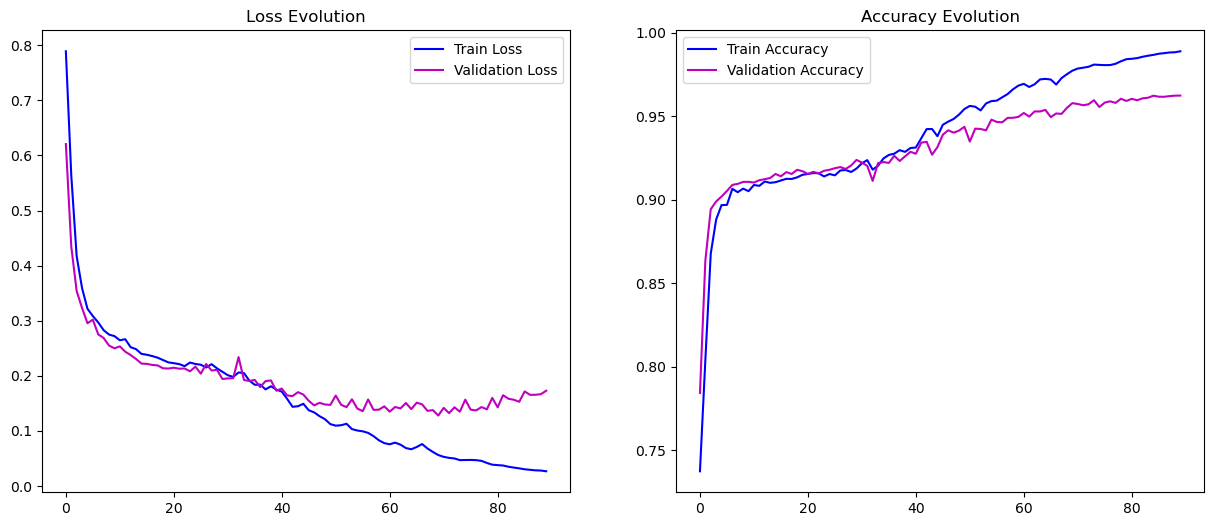

In [21]:
Loss_Acc_Evol(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


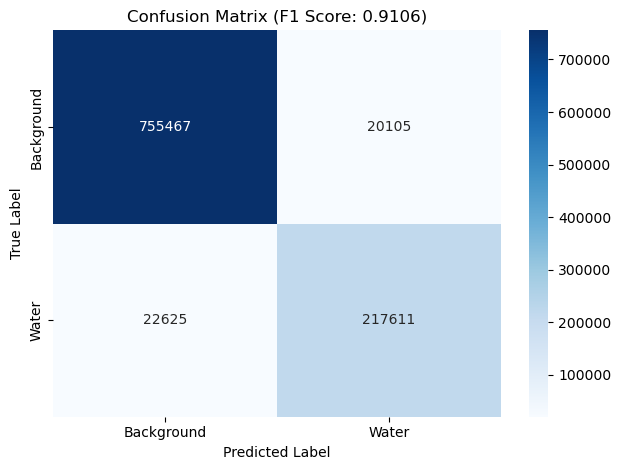

In [22]:
plot_conf_matrix(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


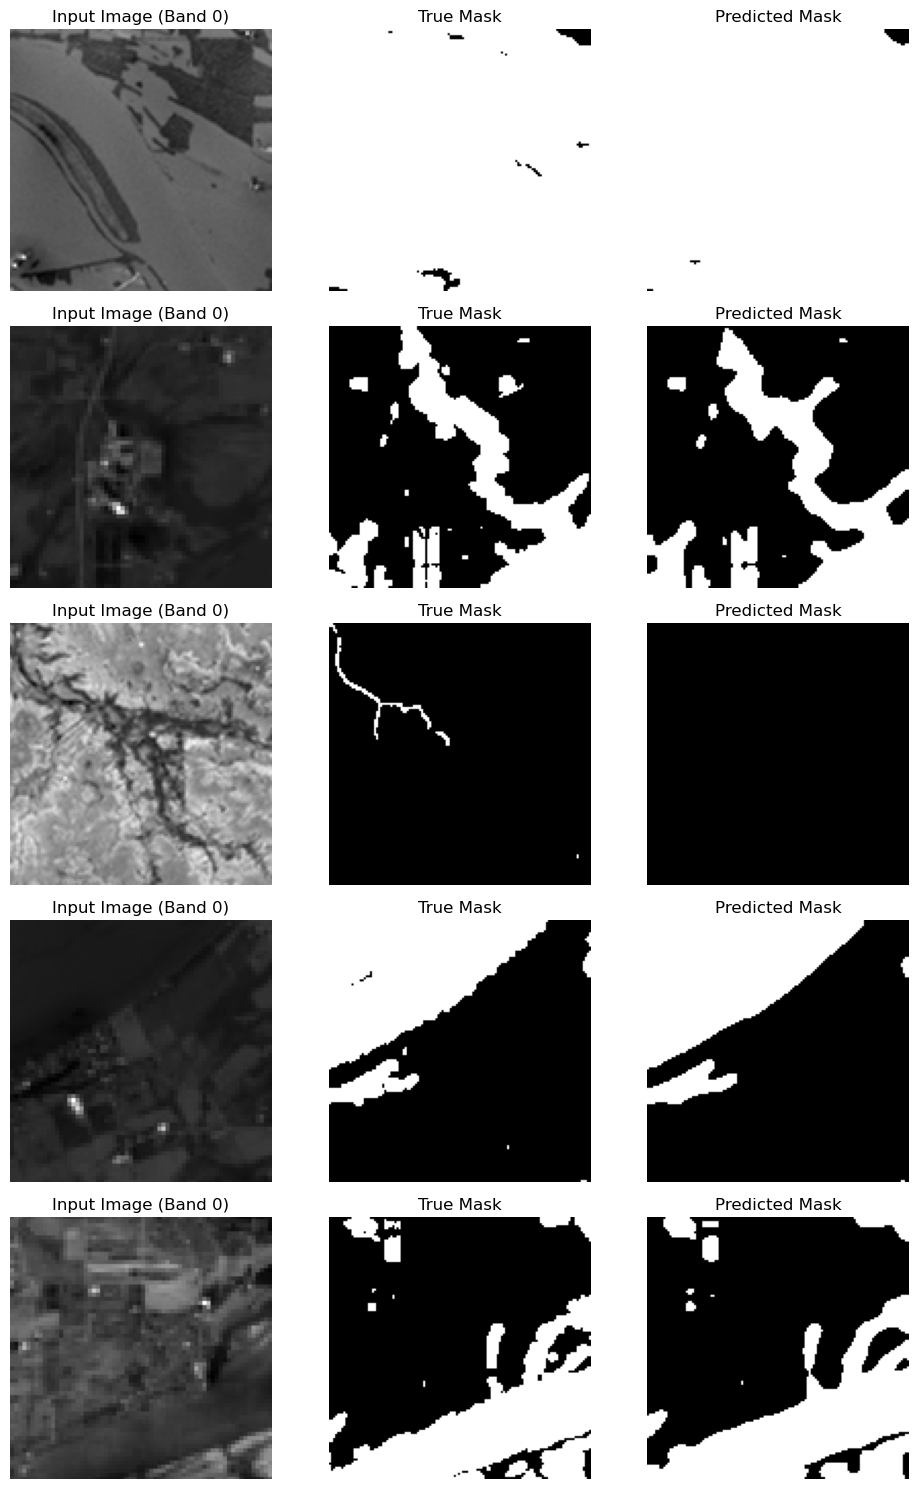

In [23]:
plot_pred_masks(model)

In [25]:
model.save('../Model/UNet_Custom.keras')

In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8, 8,      │          0 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ dropout[0][0]     │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ conv2d_9[0][0]  

 Total params: 94,152,389 (359.16 MB)

 Trainable params: 31,384,129 (119.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,768,260 (239.44 MB)

## EfficientNetV2B0

In [ ]:
def unet_pretrained_EfficientNetV2B0():
    inputs = Input((128, 128, 12))

    # Reduce channels 12 -> 3 
    x = Conv2D(3, (1, 1), activation='relu', padding='same')(inputs)

    # Encoder
    backbone = EfficientNetV2B0(include_top=False, weights="imagenet", input_shape=(128, 128, 3))
    backbone.trainable = True 

    encoder_output = backbone(x, training=False)  

    # Decoder
    u1 = UpSampling2D((2, 2))(encoder_output)
    c1 = Conv2D(1024, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.001))(u1)
    c1 = Conv2D(1024, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.001))(c1)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.3)(c1)  

    u2 = UpSampling2D((2, 2))(c1)
    c2 = Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.001))(u2)
    c2 = Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.001))(c2)
    c2 = Dropout(0.3)(c2)

    u3 = UpSampling2D((2, 2))(c2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.001))(u3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.001))(c3)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.3)(c3)

    u4 = UpSampling2D((2, 2))(c3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    c4 = Dropout(0.2)(c4)

    u5 = UpSampling2D((2, 2))(c4)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    c5 = Dropout(0.2)(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(c5)  # Final output: (128, 128, 1)

    model = Model(inputs, outputs)
    return model

In [ ]:
model_efficientb0 = unet_pretrained_EfficientNetV2B0()

history_model_efficientb0 = train(model_efficientb0)

In [ ]:
model_evaluation(model_efficientb0)

In [ ]:
Loss_Acc_Evol(history_model_efficientb0)

In [ ]:
plot_conf_matrix(model_efficientb0)

In [ ]:
plot_pred_masks(model_efficientb0)

In [ ]:
model_efficientb0.summary()

In [ ]:
model_efficientb0.save('../Model/UNet_EfficientV2B0.keras')

## ResNet34

In [26]:
BACKBONE = 'resnet34'

unet_resnet34 = Unet(
    backbone_name=BACKBONE,
    input_shape=(128, 128, 12),
    classes=1,
    activation='sigmoid', 
    encoder_weights=None  
)

In [27]:
history_unet_resnet34 = train(unet_resnet34)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7185 - iou: 0.3741 - loss: 0.5769 - precision: 0.4927 - recall: 0.5997 - val_accuracy: 0.2627 - val_iou: 0.2338 - val_loss: 11.6955 - val_precision: 0.2367 - val_recall: 0.9515
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8760 - iou: 0.6061 - loss: 0.3755 - precision: 0.7650 - recall: 0.7450 - val_accuracy: 0.2393 - val_iou: 0.2363 - val_loss: 12.1245 - val_precision: 0.2366 - val_recall: 0.9951
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8926 - iou: 0.6525 - loss: 0.3060 - precision: 0.8582 - recall: 0.7317 - val_accuracy: 0.2508 - val_iou: 0.2367 - val_loss: 9.4045 - val_precision: 0.2377 - val_recall: 0.9821
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9046 - iou: 0.6713 - loss: 0.2751 - precision: 0.8786 - recall: 0.7405 - val_accuracy: 0.4402 - val_iou: 0.2927 - val_loss: 5.5275 - val_precision: 0.2945 - val_recall: 0.9795
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1

In [28]:
model_evaluation(unet_resnet34)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step - accuracy: 0.9902 - iou: 0.9634 - loss: 0.0255 - precision: 0.9838 - recall: 0.9789
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step - accuracy: 0.9559 - iou: 0.8254 - loss: 0.1614 - precision: 0.9237 - recall: 0.8856
== Training ==
Accuracy: 0.9903, IoU: 0.9640, Precision: 0.9841, Recall: 0.9793, F1_Score: 0.9817

== Testing ==
Accuracy: 0.9594, IoU: 0.8394, Precision: 0.9288, Recall: 0.8971, F1_Score: 0.9127


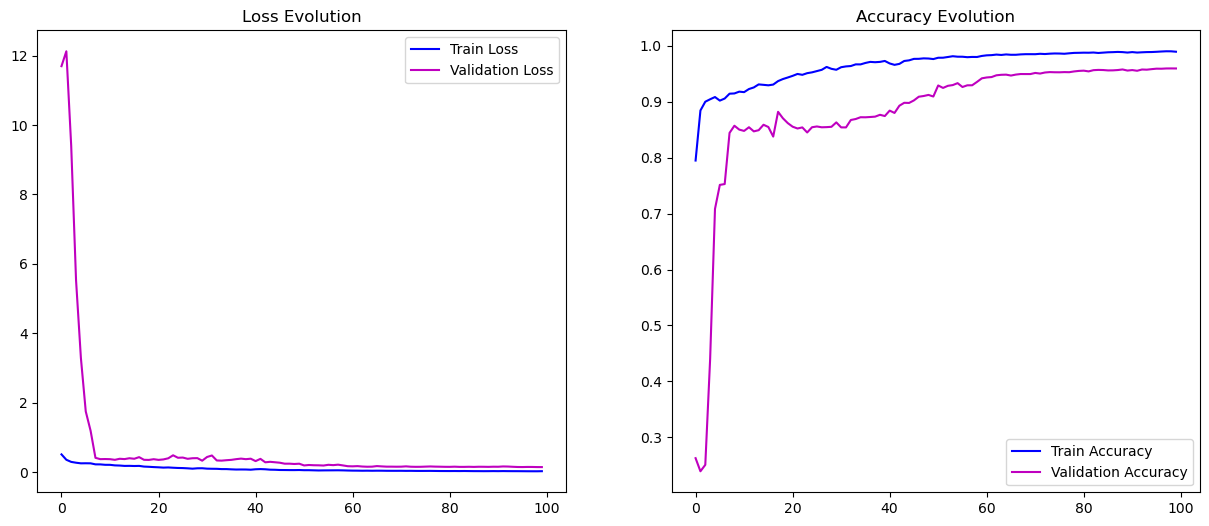

In [29]:
Loss_Acc_Evol(history_unet_resnet34)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


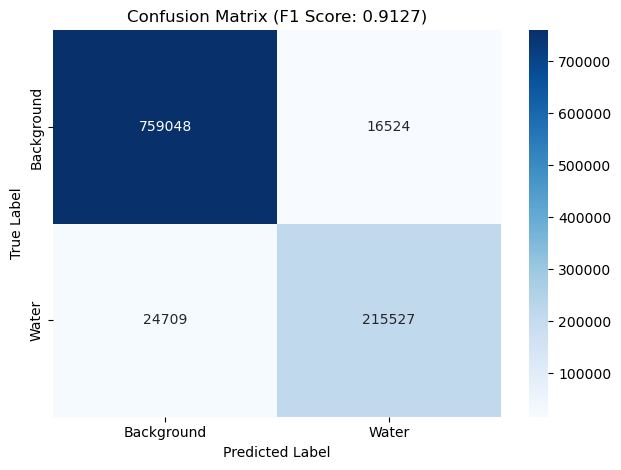

In [30]:
plot_conf_matrix(unet_resnet34)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


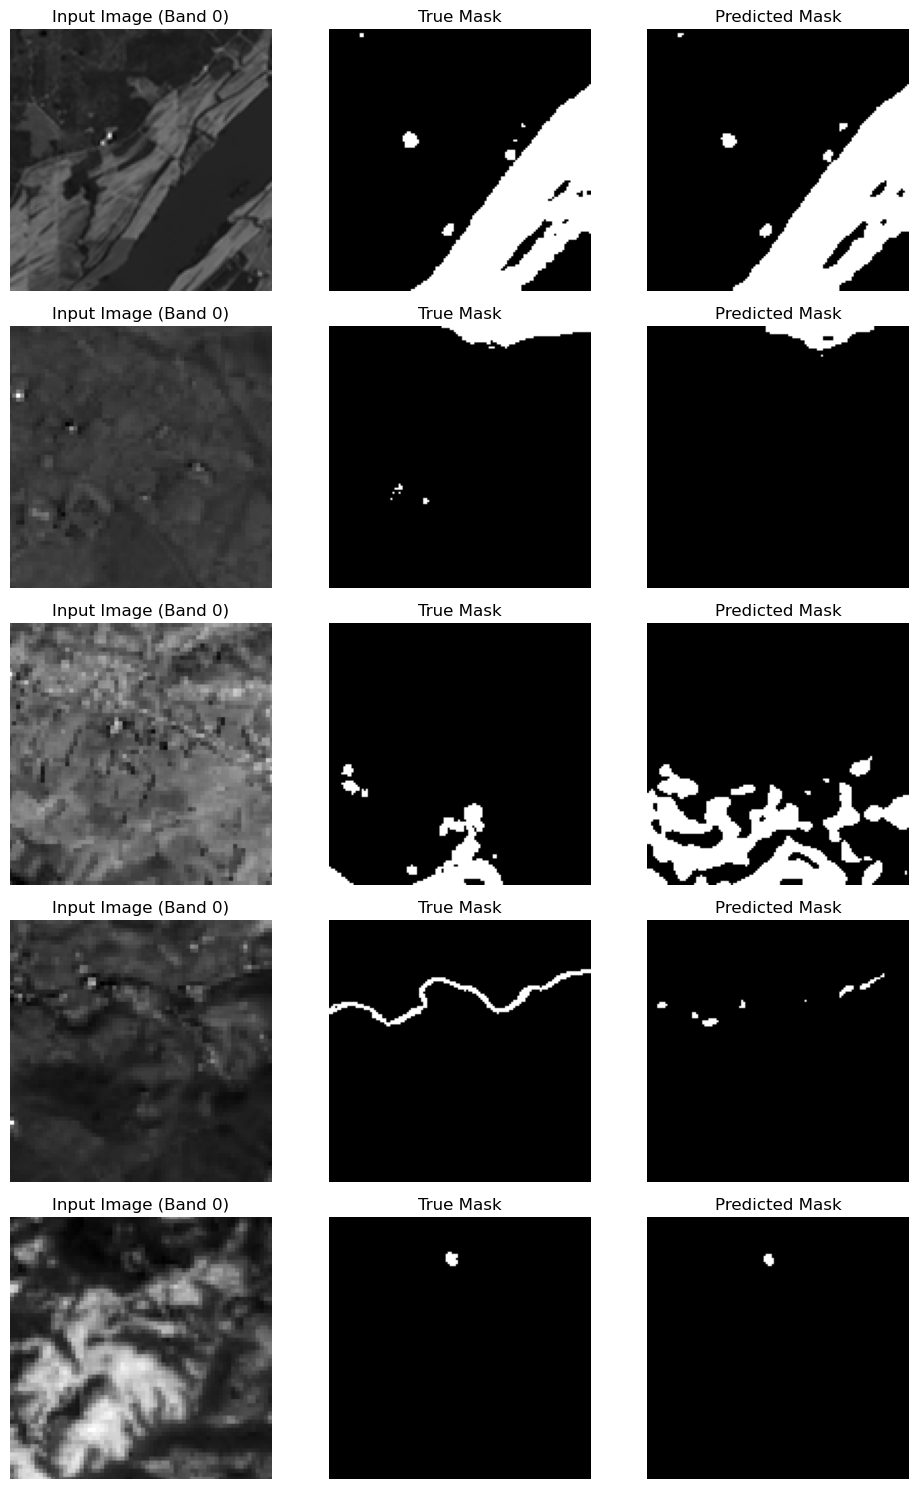

In [31]:
plot_pred_masks(unet_resnet34)

In [32]:
unet_resnet34.save('../Model/UNet_ResNet34.keras')

In [33]:
unet_resnet34.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 128, 128,  │          0 │ -                 │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 128, 128,  │         36 │ data[0][0]        │
│ (BatchNormalizatio… │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 64, 64,    │     37,632 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 64, 64,    │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 64, 64,    │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 32, 32,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 32, 32,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 32, 32,    │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 32, 32,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 32, 32,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 32, 32,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 32, 32,    │      4,096 │ stage1_unit1_rel

 Total params: 73,418,481 (280.07 MB)

 Trainable params: 24,467,037 (93.33 MB)

 Non-trainable params: 17,368 (67.84 KB)

 Optimizer params: 48,934,076 (186.67 MB)

## ResNet50

In [34]:
BACKBONE = 'resnet50'

unet_resnet50 = Unet(
    backbone_name=BACKBONE,
    input_shape=(128, 128, 12),
    classes=1,
    activation='sigmoid',
    encoder_weights=None
)

In [35]:
history_resnet50 = train(unet_resnet50)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6808 - iou: 0.3720 - loss: 0.6229 - precision: 0.4476 - recall: 0.6822 - val_accuracy: 0.3431 - val_iou: 0.2199 - val_loss: 10.4617 - val_precision: 0.2342 - val_recall: 0.7828
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8818 - iou: 0.6379 - loss: 0.4012 - precision: 0.8144 - recall: 0.7473 - val_accuracy: 0.6233 - val_iou: 0.1340 - val_loss: 6.0188 - val_precision: 0.2270 - val_recall: 0.2465
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9077 - iou: 0.6860 - loss: 0.3261 - precision: 0.8805 - recall: 0.7563 - val_accuracy: 0.6274 - val_iou: 0.1363 - val_loss: 5.8048 - val_precision: 0.2318 - val_recall: 0.2487
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9082 - iou: 0.6820 - loss: 0.2948 - precision: 0.8853 - recall: 0.7481 - val_accuracy: 0.5677 - val_iou: 0.1757 - val_loss: 4.7448 - val_precision: 0.2424 - val_recall: 0.3895
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s

In [36]:
model_evaluation(unet_resnet50)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step - accuracy: 0.8281 - iou: 0.3533 - loss: 0.4039 - precision: 0.9818 - recall: 0.3557
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 480ms/step - accuracy: 0.8491 - iou: 0.3732 - loss: 0.3774 - precision: 0.9452 - recall: 0.3815
== Training ==
Accuracy: 0.8306, IoU: 0.3667, Precision: 0.9822, Recall: 0.3692, F1_Score: 0.5367

== Testing ==
Accuracy: 0.8495, IoU: 0.3780, Precision: 0.9429, Recall: 0.3868, F1_Score: 0.5486


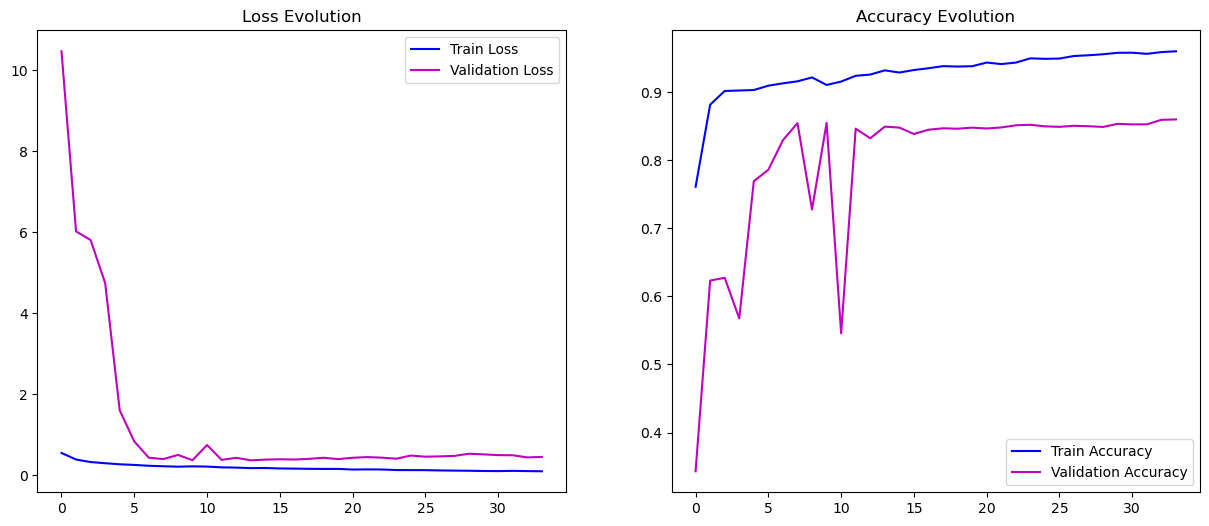

In [37]:
Loss_Acc_Evol(history_resnet50)

1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepWARNING:tensorflow:5 out of the last 15 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001709B9A93A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step


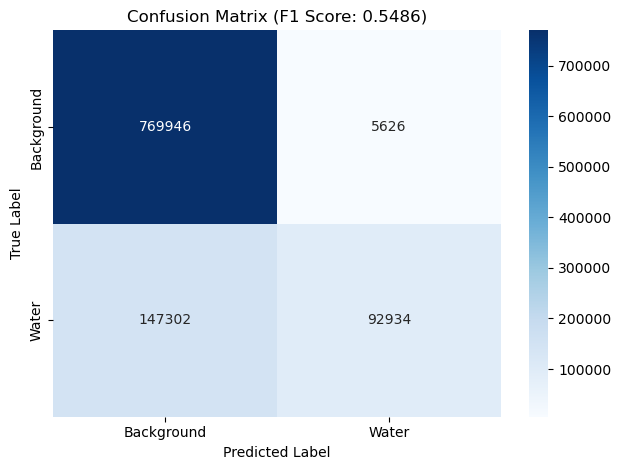

In [38]:
plot_conf_matrix(unet_resnet50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


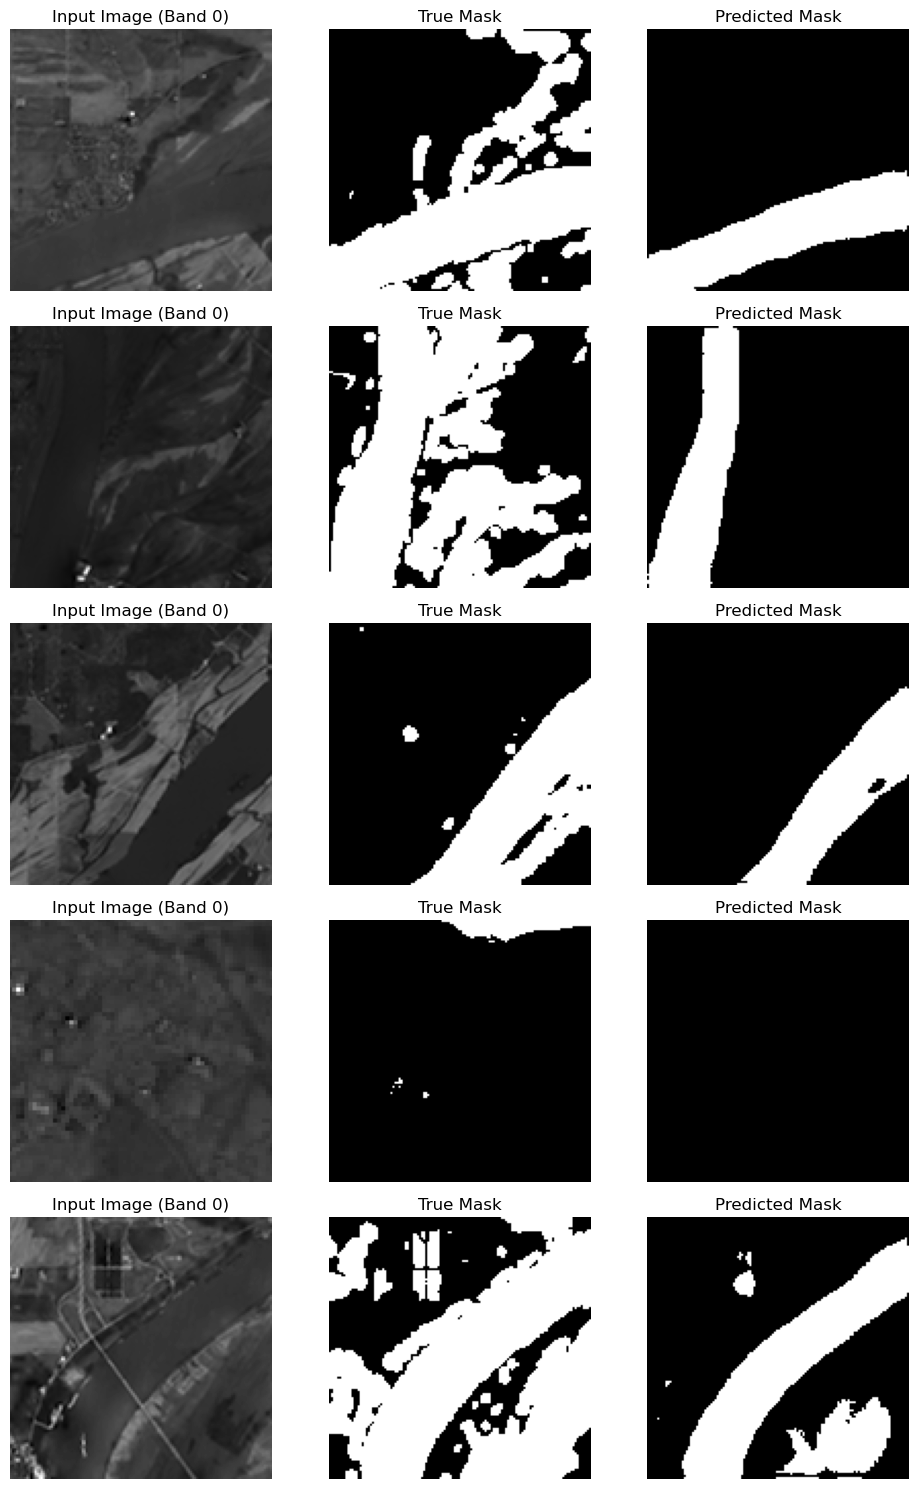

In [39]:
plot_pred_masks(unet_resnet50)

In [40]:
unet_resnet50.save('../Model/UNet_ResNet50.keras')

In [41]:
unet_resnet50.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 128, 128,  │          0 │ -                 │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 128, 128,  │         36 │ data[0][0]        │
│ (BatchNormalizatio… │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_34   │ (None, 134, 134,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 64, 64,    │     37,632 │ zero_padding2d_3… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 64, 64,    │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 64, 64,    │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_35   │ (None, 66, 66,    │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 32, 32,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 32, 32,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 32, 32,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 32, 32,    │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 32, 32,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 32, 32,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_36   │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 32, 32,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, 32, 32,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, 32, 32,    │          0 │ stage1_unit1_bn3

 Total params: 97,672,945 (372.59 MB)

 Trainable params: 32,541,789 (124.14 MB)

 Non-trainable params: 47,576 (185.84 KB)

 Optimizer params: 65,083,580 (248.27 MB)

## MobileNetV1

In [52]:
BACKBONE = 'mobilenet'

unet_mobilenet = Unet(
    backbone_name=BACKBONE,
    input_shape=(128, 128, 12),
    classes=1,
    activation='sigmoid', 
    encoder_weights=None  
)

d:\Anaconda\Lib\site-packages\keras_applications\imagenet_utils.py:276: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 12 input channels.
  warnings.warn(


In [53]:
history_mobilenet = train(unet_mobilenet)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6577 - iou: 0.3027 - loss: 0.6211 - precision: 0.4087 - recall: 0.5354 - val_accuracy: 0.7635 - val_iou: 3.7454e-05 - val_loss: 0.6577 - val_precision: 0.1385 - val_recall: 3.7463e-05
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 825ms/step - accuracy: 0.8376 - iou: 0.5324 - loss: 0.4342 - precision: 0.6896 - recall: 0.7003 - val_accuracy: 0.7635 - val_iou: 0.0000e+00 - val_loss: 0.5912 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 804ms/step - accuracy: 0.8650 - iou: 0.5928 - loss: 0.3698 - precision: 0.7523 - recall: 0.7367 - val_accuracy: 0.7635 - val_iou: 0.0000e+00 - val_loss: 0.5550 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 817ms/step - accuracy: 0.8862 - iou: 0.6154 - loss: 0.3326 - precision: 0.7894 - recall: 0.7364 - val_accuracy: 0.7635 - val_iou: 0.0000e+00 - val_loss: 0.5471 - val_precision: 0.0000e+00 - val_recall: 0.000

In [54]:
model_evaluation(unet_mobilenet)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.8705 - iou: 0.5476 - loss: 0.3908 - precision: 0.8761 - recall: 0.5936
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8722 - iou: 0.4933 - loss: 0.3904 - precision: 0.8821 - recall: 0.5280
== Training ==
Accuracy: 0.8716, IoU: 0.5534, Precision: 0.8794, Recall: 0.5988, F1_Score: 0.7125

== Testing ==
Accuracy: 0.8749, IoU: 0.5023, Precision: 0.8945, Recall: 0.5339, F1_Score: 0.6687


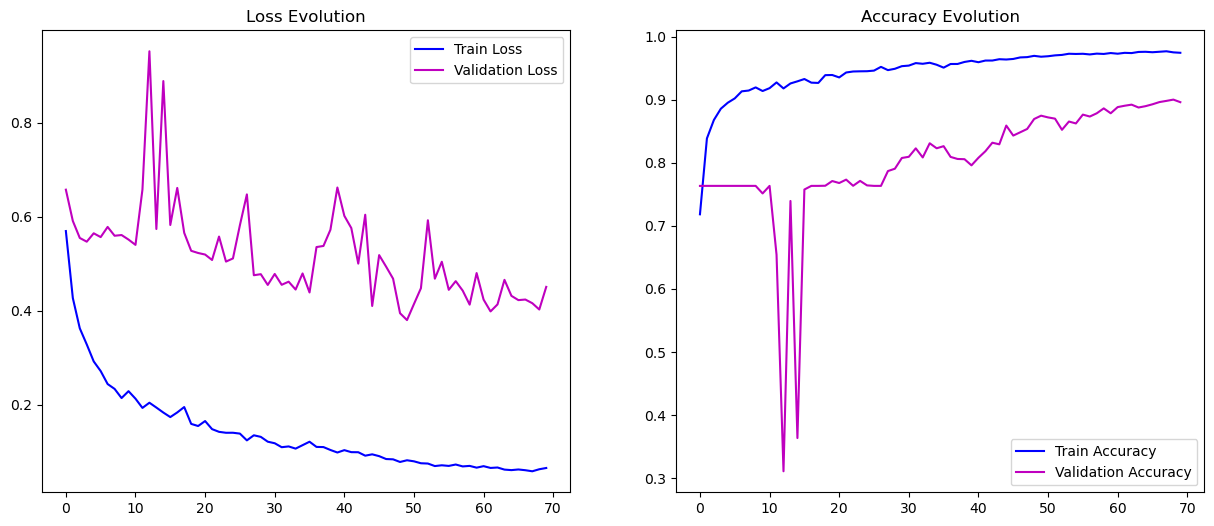

In [55]:
Loss_Acc_Evol(history_mobilenet)

1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepWARNING:tensorflow:5 out of the last 15 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000172BBB40220> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


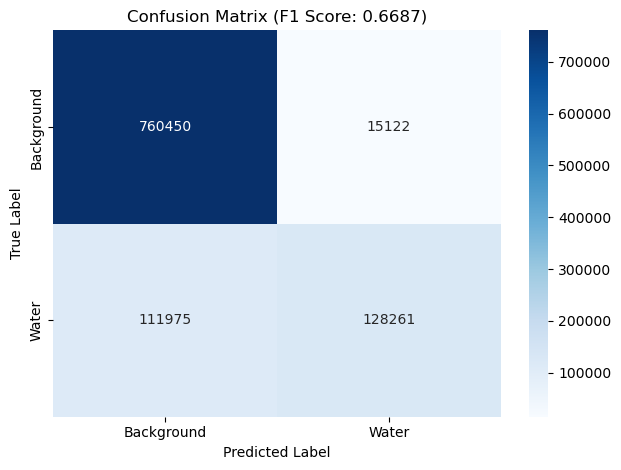

In [56]:
plot_conf_matrix(unet_mobilenet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


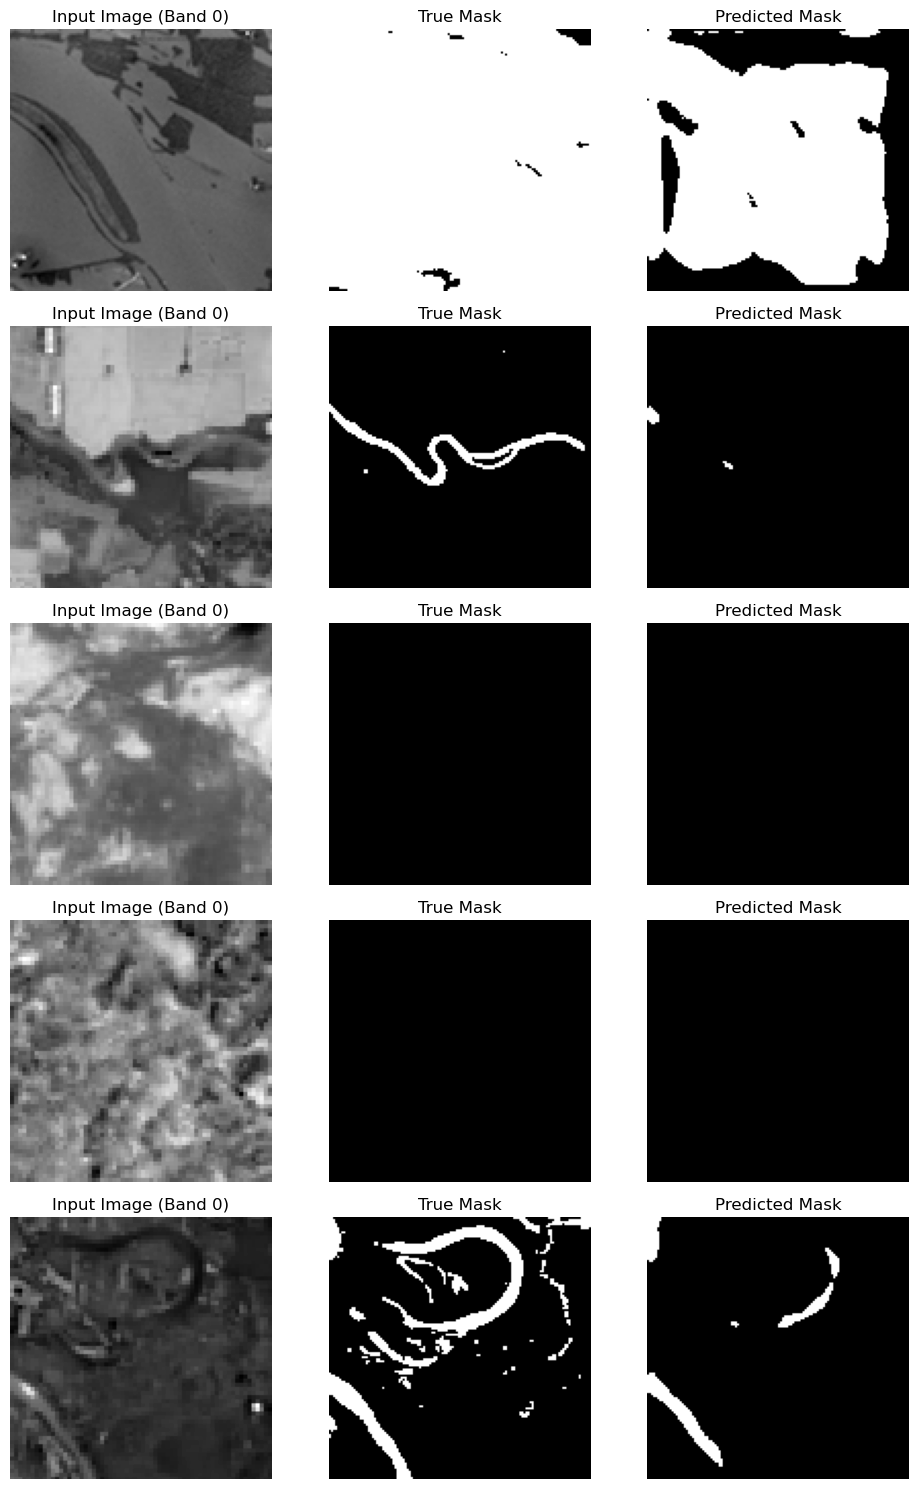

In [57]:
plot_pred_masks(unet_mobilenet)

In [58]:
unet_mobilenet.save('../Model/UNet_MobileNet.keras')

In [59]:
unet_mobilenet.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 129, 129,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 64, 64,    │      3,456 │ conv1_pad[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1           │ (None, 64, 64,    │        288 │ conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_bn        │ (None, 64, 64,    │        128 │ conv_dw_1[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_relu      │ (None, 64, 64,    │          0 │ conv_dw_1_bn[0][… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1 (Conv2D)  │ (None, 64, 64,    │      2,048 │ conv_dw_1_relu[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_bn        │ (None, 64, 64,    │        256 │ conv_pw_1[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_relu      │ (None, 64, 64,    │          0 │ conv_pw_1_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pad_2          │ (None, 65, 65,    │          0 │ conv_pw_1_relu[0… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2           │ (None, 32, 32,    │        576 │ conv_pad_2[0][0]  │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_bn        │ (None, 32, 32,    │        256 │ conv_dw_2[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_relu      │ (None, 32, 32,    │          0 │ conv_dw_2_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2 (Conv2D)  │ (None, 32, 32,    │      8,192 │ conv_dw_2_relu[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_bn        │ (None, 32, 32,    │        512 │ conv_pw_2[0][0] 

 Total params: 24,969,045 (95.25 MB)

 Trainable params: 8,315,057 (31.72 MB)

 Non-trainable params: 23,872 (93.25 KB)

 Optimizer params: 16,630,116 (63.44 MB)

# Model Dataframe

In [61]:
model_names = ['Custom UNet', 'ResNet34', 'ResNet50', 'MobileNetV1']
models = [model, unet_resnet34, unet_resnet50, unet_mobilenet]

results = []

for name, model in zip(model_names, models):
    test_loss, test_acc, test_iou, test_prec, test_rec = model.evaluate(np.array(x_test), np.array(y_test), verbose=0)
    results.append({'Model Name': name, 'Accuracy': test_acc, 'IoU': test_iou})

df = pd.DataFrame(results)
df

Model Name  Accuracy       IoU
0  Custom UNet  0.874881  0.502279
1     ResNet34  0.959409  0.839410
2     ResNet50  0.849452  0.377992
3  MobileNetV1  0.874881  0.502279

In [62]:
best_model = df.loc[df['IoU'].idxmax()]
print(f'Best Model Based on IoU: {best_model['Model Name']}')

Best Model Based on IoU: ResNet34


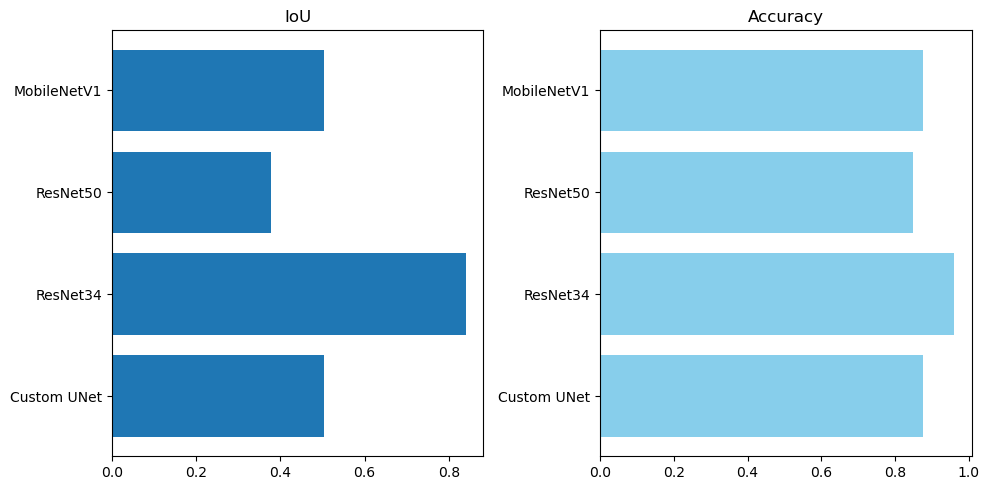

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.barh(df['Model Name'], df['IoU'])
ax1.set_title('IoU')

ax2.barh(df['Model Name'], df['Accuracy'], color='skyblue')
ax2.set_title('Accuracy')

plt.tight_layout()
plt.show()